In [32]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns;
import xarray as xr
sns.set_style('ticks')
from pathlib import Path
from matplotlib import cm  # For waterfall plot
from matplotlib.ticker import LinearLocator, FormatStrFormatter  # For waterfall plot
from utils import get_df, get_plot_df, get_sklearn_df, plot_heatmap_all_polarizations, plot_waterfall_all_polarizations

# Ignore warnings in this notebook
import warnings; warnings.simplefilter('ignore')

# Set matplotlib to plot in notebook
%matplotlib inline

# Automatically prints execution time for the individual cells
%load_ext autotime

# Automatically reloads functions defined in external files
%load_ext autoreload
%autoreload 2

# The path to the project (so absoute file paths can be used throughout the notebook)
PROJ_PATH = Path.cwd().parent

# Set seed for random generators
RANDOM_SEED = 42

# Seed the random generators
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
time: 30.4 ms


The Excel sheet had attributes cleaned (ie. one empty row was removed and a typo in one of the years were corrected). Then the field_ids were found in QGIS based on the Markbloknr. and MARK NR., and added as an additional column in the Excel sheet.

In [168]:
# Load Excel sheet with infected fields
infected_fields_excel_sheet_path = PROJ_PATH / 'data' / 'external' / 'Projekt_KCN_med_AU_renset_for_navn_til_pandas.xlsx'
df_infected_fields = pd.read_excel(infected_fields_excel_sheet_path)

# Show the resulting dataframe
df_infected_fields

,MARK NR.,Markbloknr.,Areal str. Ha,Sæson,Type,Infektion cyster i prøver,Cyster i prøver af alle,Infektion grupperet,field_id
0,152-0,503185-64,3.15,2017,Pa,3,1 a 3,lav,40188130
1,20-1,869116-05,1.90,2017,"Ro, Pa",30,2 a 2,høj,42910247
2,13-0 (13-1),646132-12,2.43,2018,Ro,45,3 a 3,høj,49828969
3,37-0,508213-24,7.12,2018,Ro,15,1 a 6,middel,53031770
4,14-0 (14-1),507226-99,4.60,2018,Pa,25,2 a 3,høj,49943872
5,19-1,658182-12,2.50,2018,Ro,15,1 a 2,høj,49922598
6,1-1,58424090,0.50,2018,Ro,15,1 a 1,høj,50318905
7,402-0,510102-06,2.45,2018,Pa,2,2 a 8,lav,49740277
8,9-0,497230-39,3.56,2019,pa,43,3 a 3,høj,62011804
9,4-0,492535-88,10.96,2019,Pa,131,9 a 9,høj,Invalid Markbloknr.


time: 58.2 ms


Analyzing 2017 season for crop type: Kartofler, stivelses-


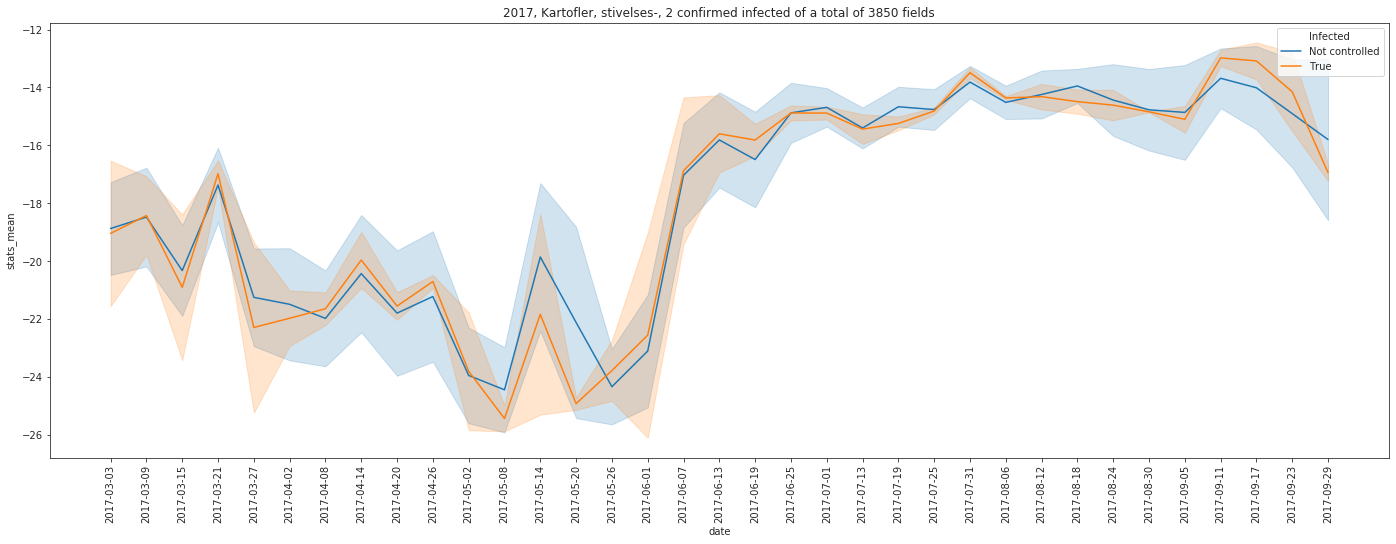

Analyzing 2017 season for crop type: Kartofler, spise-


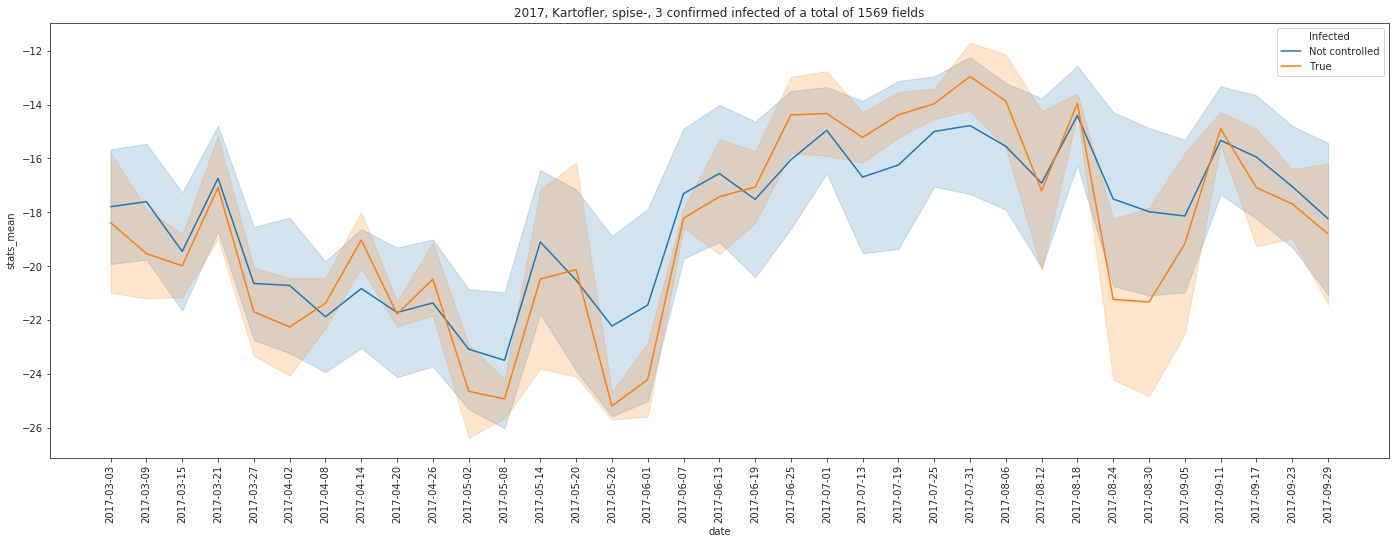

Analyzing 2017 season for crop type: Kartofler, andre


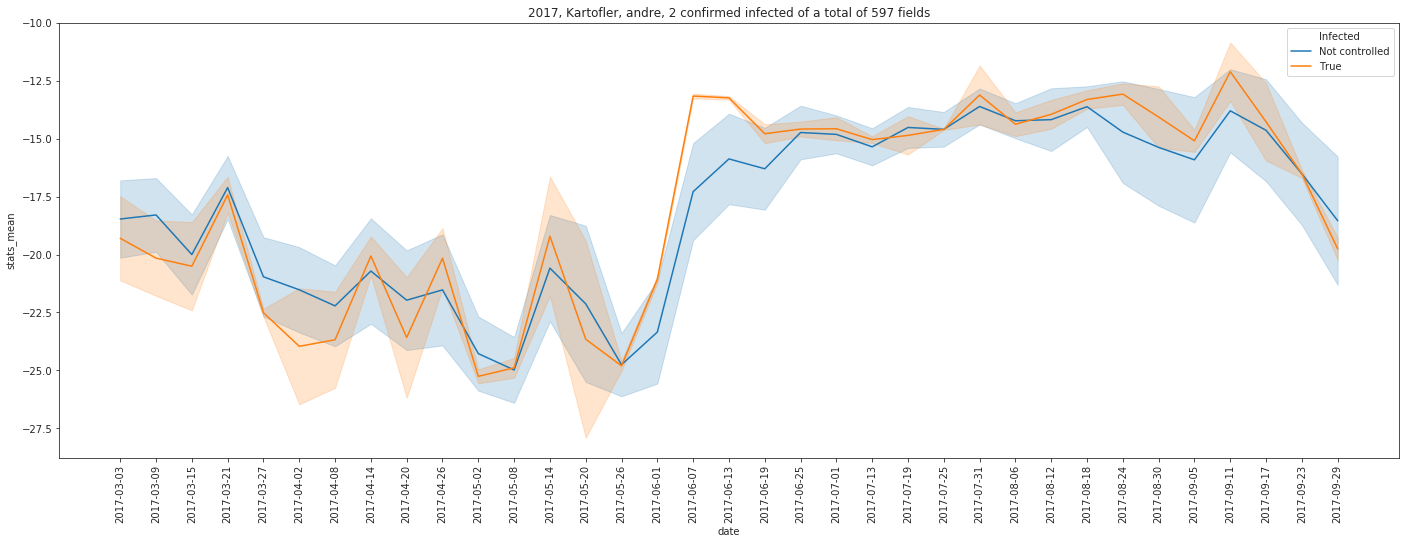

Analyzing 2018 season for crop type: Kartofler, stivelses-


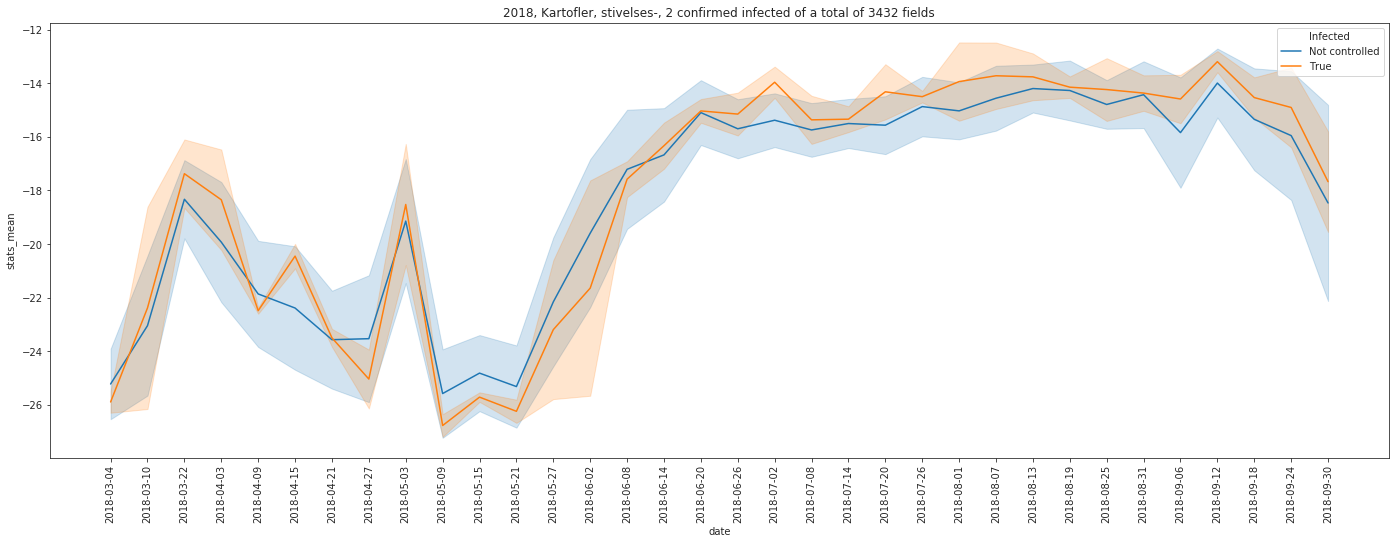

Analyzing 2018 season for crop type: Kartofler, spise-


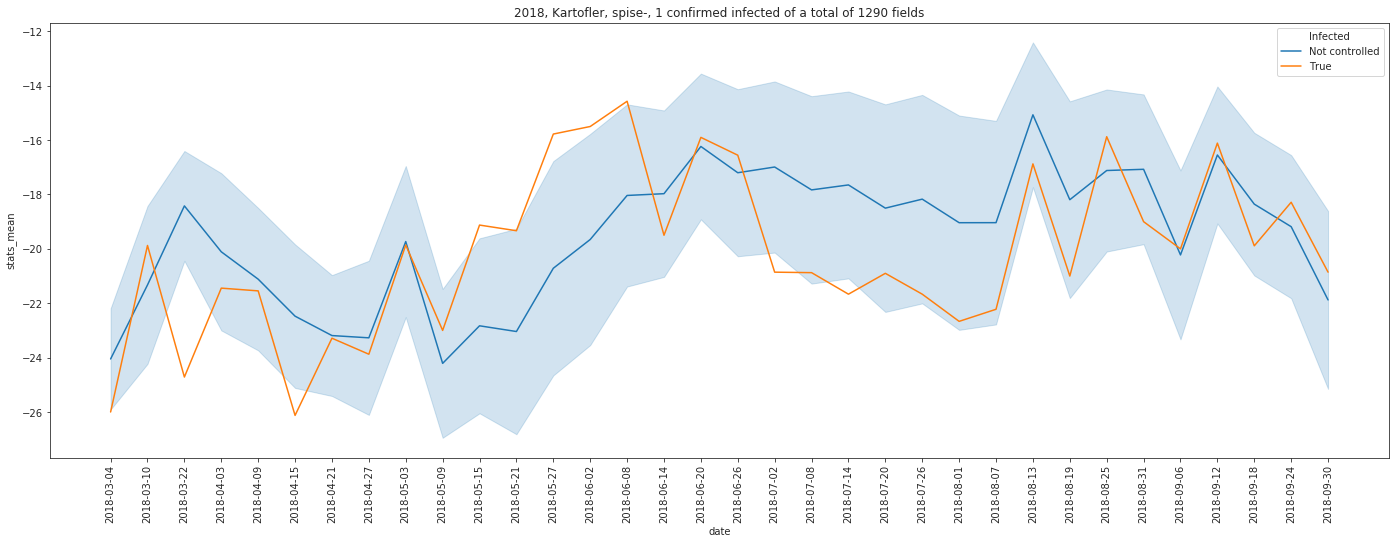

Analyzing 2018 season for crop type: Kartofler, lægge- (egen opformering)


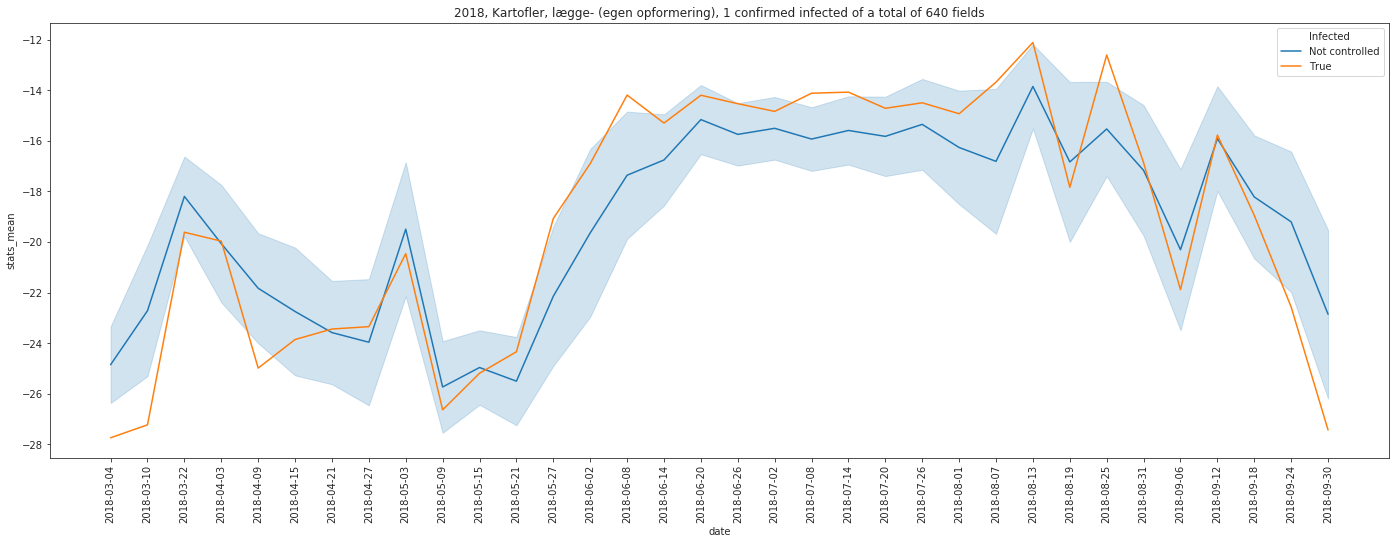

Analyzing 2019 season for crop type: Kartofler, stivelses-


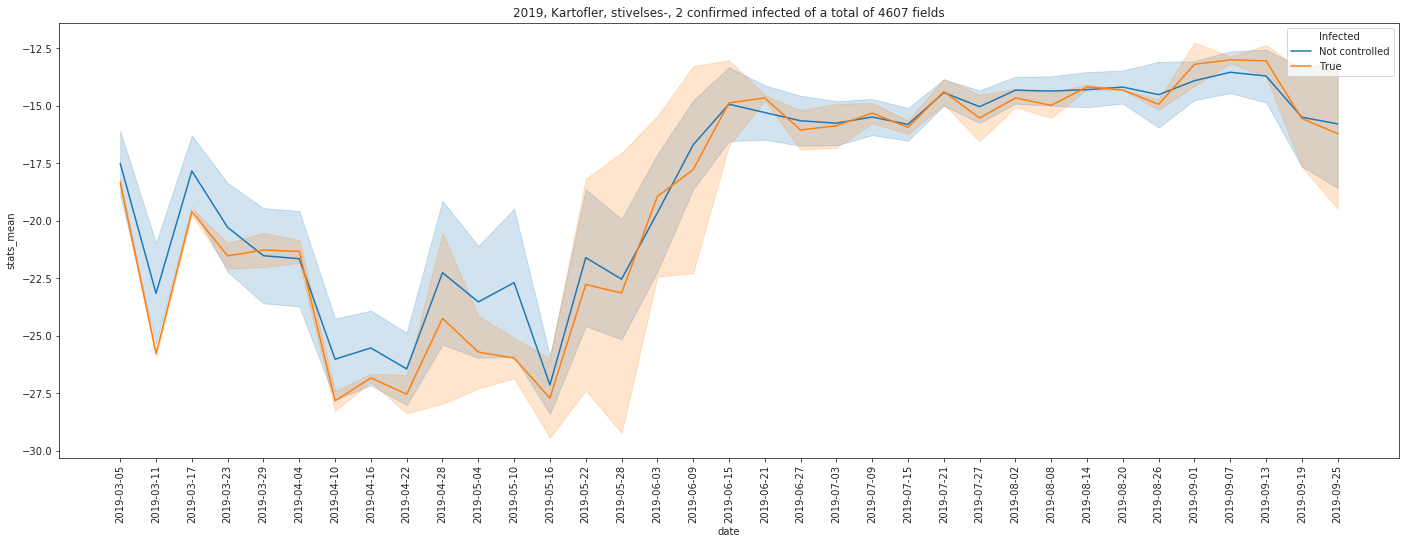

Analyzing 2019 season for crop type: Kartofler, spise-


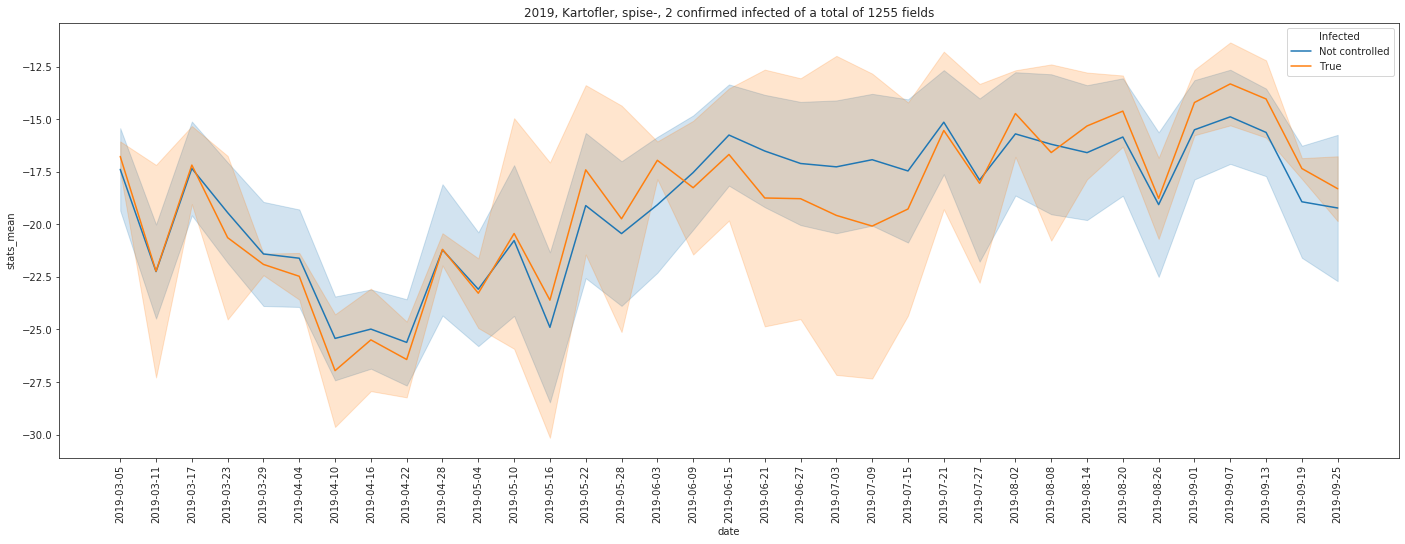

time: 50.9 s


In [170]:
for year in range(2017,2020):
    # Load dataframe
    df = get_df(polygons_year=year, 
                satellite_dates=slice(f'{year}-01-01', f'{year}-12-31'), 
                fields='all',#range(100), 
                satellite='all', 
                polarization='VH')

    # Get field ids of the infected fields for the specific year
    df_infected_fields_year = df_infected_fields[df_infected_fields['Sæson'] == year] 
    infected_field_ids = df_infected_fields_year['field_id'].values
    
    # Add 'infected' column with True/False if Infected/Not-infected
    df['Infected'] = ['True' if x in infected_field_ids else 'Not controlled' for x in df['field_id']]
    
    # Loop over the crop types and plot the temporal evolution
    infected_crop_types = df[df['Infected'] == 'True']['afgroede'].unique()
    for i, crop_type in enumerate(infected_crop_types):
        print(f"Analyzing {year} season for crop type: {crop_type}")
        df_plot = df[df['afgroede'] == infected_crop_types[i]]
        num_total_fields = len(df_plot['field_id'].unique())
        num_infected = len(df_plot[df_plot['Infected'] == 'True']['field_id'].unique())

        # Format the dataframe to work well with Seaborn for plotting
        df_plot['date'] = df_plot['date'].dt.strftime('%Y-%m-%d')
        df_plot['field_id'] = ['$%s$' % x for x in df_plot['field_id']]  # https://github.com/mwaskom/seaborn/issues/1653
        df_plot['afgkode'] = ['$%s$' % x for x in df_plot['afgkode']]  # https://github.com/mwaskom/seaborn/issues/1653
        df_plot['relative_orbit'] = ['$%s$' % x for x in df_plot['relative_orbit']]  # https://github.com/mwaskom/seaborn/issues/1653

        # Plot
        plt.figure(figsize=(24, 8))
        plt.xticks(rotation=90, horizontalalignment='center')
        plt.title(f"{year}, {crop_type}, {num_infected} confirmed infected of a total of {num_total_fields} fields")
        ax = sns.lineplot(x='date', y='stats_mean', hue='Infected', data=df_plot, ci='sd')
        plt.show()